# Laboratorio 4

Integrantes: 

    - Francis Aguilar - 22243 
    - Diego García - 22404 
    - Angela García -22869 

enlace al repositorio: https://github.com/angelargd8/lab4-modsim

# Ejercicio 1


## Teoría 
Defina y responda
1. Comparar la simulación de tiempo discreto (síncrona) y de tiempo continuo (asíncrona):

    a. Describir escenarios donde cada una es preferible

    b. Analizar las compensaciones computacionales (velocidad vs. precisión).

| tiempo discreto (síncrona) | tiempo continuo (asíncrona) |
|:-----|:--------:|
|Def:  El tiempo avanza en saltos fijos y en cada salto todos los eventos que ocurren en ese instante se procesan de forma sincronizada, antes de anvanzar al siguiente intervalo| Def: El tiempo fluye de manera continua y el motor de simulación salta directamente de un evento al siguiente sin procesar intervalos vacíos|
| Todos los eventos del intervalo se procesan juntos| Cada evento se procesa en el momento exacto|
| La precisión temporal está limitada por el tamaño de Δt| La presición temporal es muy alta, es exacta al instante de ocurrencia |
| Más simple de implementar | Es más compleja porque tiene una gestión de lista de eventos |
| En cuanto velocidad puede ser más lenta si Δt es pequeño, porque tiene muchos pasos| Es más eficiente si hay pocos eventos|
| En escenarios que es prefreribles es en simulaciones por turnos, modelos físicos simplificados y autómatas celulares | Este es mejor en escenariso de redes de colas, tráfico procesos industriales en tiempo real|
| Acerca de la compensacion computacional, es que es muy rápido de implementar y ejecutar cuando el intervalo de tiempo es grande, pero si se necesita mucha precisión temporal, se tiene que usar un intervalo de tiempo muy pequeño y eso incrementa exponencialmente el número de pasos y reduce la velocidad. La precisión está límitada por el tamaño de Δt, si es grande es menos preciso, pero más rápido. Y si Δt pequeño es más preciso, pero más lento| En cuanto a velocidad no simula intervalos vacíos, este solo salta de un evento a otro y eso puede ser muy eficiente si es que son pocos eventos. La desventaja que tiene es la gestión de la lista de eventos ordenada por tiempo, porque esto si añade sobrecarga ocmputacional, si hay muchos eventos por segundo. Aunque, su presición es muy alta, ya que maneja tiempos exactos para cada evento y no depende de Δt, sino que de la exactitud de los cálculos y del reloj del simulador|

2. Sobre los mecanismos de gestión de eventos:

    a. Explicar cómo las colas de eventos gestionan los cambios de estado.

    Las colas de eventos gestionan los cambios de estados, ya que estos son una estructura de datos que tienen todos los elementos futuros programados en la simulación, entonces cada evento tiene tiempo de ocurrencia, tiempo de evento y datos asociados. La cola siempre está ordenada por tiempo de ocurrencia para que el próximo evento se accesible de una manera rápida. Con el ciclo típico de simulacion con cola de eventos primero se inicializa, creando los primeros eventos con las condiciones iniciales y se insertan en la cola con sus tiempos de ejecución. Luego en el bucle de simulación mientras existan eventos y no se llegue al tiempo final, se extrae el evento más próximo, se avanza elreloj de simulación al tiempo de ese evento, se procesa el evento para actualizar estados de entidades y se genera nuevos eventos que surjan como consecuencia y se añaden a la cola, por último, se detiene cuando no hay más eventos o se alcanza la condición de fin. 

    b. Analizar la gestión de prioridades para eventos concurrentes.

    La gestión de prioridades para eventos concurrentes es algo que puede llegar a ser delicado al trabajar con colas de eventos, se suele trabajar con tiempo continuo. La gestión de prioridades lo que define es en qué orden se procesan para mantener la coherencia y reproducibilidad del modelo. Se usa como criterio principal que se ordenan por el tiempo de ocurrencia. Y como criterios secundarios que se puede usar una prioridad fija por tipo de evento o reglas dependientes del estado del sistema. Y para los resultados si tiempo y tipo son iguales, se usa el orden FIFO de la cola para asegurar resultados deterministas. Entonces, si se tiene una buena gestión se evitan errores como resultados no reproducibles, estados invalidos, inconsistencias en la lógica y se implementan estructuras como priority queues que perminten ordenar por múltiples claves y mantener un orden.


In [ ]:
# %pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import math
from collections import defaultdict, Counter
import simpy
from dataclasses import dataclass
from enum import Enum, auto

# Ejercicio práctico: marco de simulación

# escenario: propagación de enfermedades en un hospital

# arquitecturas: 
# 1. tiempo discreto - actualizaciones diarias
# 2. tiempo continuo - infecciones impultadas por eventos 
# atributos necesarios de cada agente
#tipos de eventos a monotorizar
#metricas de salida esperadas

#estados 
class Salud(Enum):
    S = auto() #suceptible
    E= auto() #expuesto
    I= auto() #infeccioso
    R= auto() #recuperado

#modelo
@dataclass #los dataclass los siento muy c xd
class Agent: 
    id: int
    rol: str
    estado: Salud= Salud.S
    t_inf_ini: float = None
    t_rec: float = None

@dataclass
class Params:
    T: int = 30 #dias a simular
    tasa_contacto: float = 2.0 #contactos promedio por dia por agente
    contactos_dia: int = 40 #contactos aleatorios por dia 
    beta_contacto: float = 0.15 #riesgo base por contacto
    inc_media: float = 3.0 #media de incubacion
    inf_media: float = 5.0 #media de infeccioso

def utilidad(mean):
    return random.expovariate(1.0/mean)

def p_trans(beta):
    prob_por_contacto = 1.0 - math.exp(-beta)
    return prob_por_contacto

def tiempoDiscreto(agents, params):
    semilla = 42
    random.seed(semilla)
    env = simpy.Environment()
    #metricas

    incidencia = {d: 0 for d in range(params.T)}
    prevalencia = [] #T, i
    

    #flujo - por dia en d tiempo
    def tick_diario(env): 
        for d in range(params.T):    
        #generar contacots dia
            ids = list(range(len(agents)))
            #por cada contacto en contactos
            for i in range(params.contactos_dia):
                a, b= random.sample(ids, 2)
                A, B= agents[a], agents[b]

                #intentar transmision
                for emisor, receptor in [(A, B), (B, A)]:
                    if emisor.estado ==Salud.I and receptor.estado == Salud.S:
                        if random.random() < p_trans(params.beta_contacto):
                            receptor.estado = Salud.E
                            receptor.t_inf_ini = d + utilidad(params.inc_media)
                            receptor.t_rec = receptor.t_inf_ini + utilidad(params.inf_media)
                            incidencia[d] += 1
                            # prevalencia.append((d, receptor))


            # propagacion por marcas
            for a in agents: 
                if a.estado == Salud.E and a.t_inf_ini is not None and a.t_inf_ini <= d+1:
                    a.estado = Salud.I
                if a.estado == Salud.I and a.t_rec is not None and a.t_rec <= d+1:
                    a.estado = Salud.R

            # recolectar metricas
            I = sum(a.estado == Salud.I for a in agents)
            prevalencia.append((d+1, I))

            #avanzar al siguiente dia
            yield env.timeout(1)

    env.process(tick_diario(env))
    env.run(until=params.T)
    return {"incidencia": incidencia, "prevalencia": prevalencia}

def tiempoContinuo(agents, params: Params):
    random.seed(42)
    env = simpy.Environment()

    incidencia_t = [] # tiempos exactos de infección 
    incidencia_dia = defaultdict(int) # conteo por día 
    prevalencia_t = []  #snapshots diarios

    def registrar_infeccion(t: float):
        incidencia_t.append(t)
        incidencia_dia[int(t)] += 1

    def progression(env, a: Agent):
        # Incubacion
        yield env.timeout(utilidad(params.inc_media))
        if a.estado != Salud.E:
            return
        a.estado = Salud.I
        # Infeccioso
        yield env.timeout(utilidad(params.inf_media))
        if a.estado == Salud.I:
            a.estado = Salud.R

    def recovery_if_I(env, a: Agent):
        # Para quien ya está en I al inicio: programa su recuperación una sola vez
        yield env.timeout(utilidad(params.inf_media))
        if a.estado == Salud.I:
            a.estado = Salud.R

    def contactos_actor(env, a: Agent):
        # Proceso generador de contactos para el agente
        while env.now < params.T:
            wait = utilidad(1.0 / params.tasa_contacto) if params.tasa_contacto > 0 else params.T
            yield env.timeout(wait)

            #elegir otro
            otros = [x for x in agents if x.id != a.id]
            if not otros:
                continue
            b = random.choice(otros)

            # Intentar transmision
            for em, rc in ((a, b), (b, a)):

                if em.estado == Salud.I and rc.estado == Salud.S:
                    if random.random() < p_trans(params.beta_contacto):
                        rc.estado = Salud.E
                        registrar_infeccion(env.now)
                        env.process(progression(env, rc))

    # sino hay infecciosos iniciales siembra uno
    hay_I = any(a.estado == Salud.I for a in agents)
    if not hay_I and agents:
        agents[0].estado = Salud.I

    #recuperación
    for a in agents:
        if a.estado == Salud.I:
            env.process(recovery_if_I(env, a))

    # procesos de contacto
    for a in agents:
        env.process(contactos_actor(env, a))

    # snapshot diario 
    def snapshot_diaria(env):
        while env.now < params.T:
            I = sum(x.estado == Salud.I for x in agents)
            prevalencia_t.append((int(env.now), I))
            yield env.timeout(1)
    env.process(snapshot_diaria(env))

    env.run(until=params.T)

    return { "incidencia_t": incidencia_t, "incidencia_dia": dict(incidencia_dia), "prevalencia_t": prevalencia_t }

In [3]:
from copy import deepcopy 

# hospital
agents_A = [Agent(i, "paciente" if i < 15 else "personal") for i in range(25)]
agents_B = [Agent(i, "paciente" if i < 15 else "personal") for i in range(25)]

# Discreto
P = Params()
#sembrar un caso inicial
agents_A[0].estado = Salud.I
agents_A[0].t_rec = utilidad(Params().inf_media)
res_discreto = tiempoDiscreto(deepcopy(agents_A), P)
print("-- discreto -- ")
print("Incidencia por día :\n ", res_discreto["incidencia"])
print("Prevalencia : \n" , res_discreto["prevalencia"])

#b
agents_B[0].estado = Salud.I
agents_B[1].estado = Salud.I
res_cont = tiempoContinuo(deepcopy(agents_B), P)
print("\n-- continuo --")
print("Infecciones (tiempos):", res_cont["incidencia_t"])
print("Incidencia por día:", res_cont["incidencia_dia"])
print("Prevalencia ", res_cont["prevalencia_t"])


-- discreto -- 
Incidencia por día :
  {0: 1, 1: 0, 2: 3, 3: 2, 4: 2, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}
Prevalencia : 
 [(1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 4), (7, 4), (8, 5), (9, 3), (10, 3), (11, 2), (12, 2), (13, 3), (14, 2), (15, 3), (16, 4), (17, 4), (18, 5), (19, 4), (20, 5), (21, 4), (22, 3), (23, 2), (24, 1), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0)]

-- continuo --
Infecciones (tiempos): [1.1047400053375287, 3.1818517394059684, 10.610633456160713, 12.508767960303466, 12.898323451553098, 12.978188575070948, 13.10305866859496, 13.879364980524894, 14.192871421100953, 14.595768824811277, 15.040153183382227, 15.426755937204417, 15.698902209734, 16.650449333637184, 17.28867572251684, 17.46200267269659, 18.060545417415867, 23.26930019276963, 23.491346975554617, 26.845619063032427]
Incidencia por día: {1: 1, 3: 1, 10: 1, 12: 3, 13

# Ejercicio 2
### Teoría 

1. Considere la taxonomía de rasgos, clasifique y justifique cada uno de los siguientes (discreto, contínuo o
relacional) 

| Aspecto | Clasificación | Justificación |
|:-----|:--------|:-----|
|Edad|Contnuo |Se mide en una escala numérica y puede tomar cualquier valor dentro de un rango. Es un atributo cuantitativo que refleja magnitud y permite operaciones matemáticas.|
|Profesión|Discreto |Corresponde a categorías nominales (médico, ingeniero, profesor, etc.), mutuamente excluyentes y no ordenadas.|
|Redes de amistad| Relacional |Describe vínculos o relaciones entre individuos y no es un atributo de un solo individuo, sino de pares o grupos de individuos.|
|Estado de vacunación|Discreto|Se expresa en categorías finitas. No se mide en escala numérica continua, sino en valores categóricos.

2. Calcule el tamaño total del espacio de parámetros y responda ¿cómo podría afectar esto al tiempo de
ejecución de la simulación? Para esto, considere un escenario de 10,000 agentes con:

a. 3 rasgos continuos (p. ej., tasa de movilidad).  

10,000 agentes × 3 rasgos continuos por agente = 30,000 dimensiones.
Si acotas cada rasgo a un intervalo (p. ej., [0,1]), el espacio sigue siendo infinito, pero su “volumen” es el producto de longitudes de cada dimensión. Con [0,1] para cada rasgo: volumen = 1^30,000 = 1, aunque con cardinalidad infinita.  


b. 2 rasgos discretos (p. ej., ocupación)



### Ejercicio práctico

Construya un perfil poblacional heterogéneo para un escenario de “Respuesta a una pandemia urbana”, para ello
considere las siguientes tareas

In [3]:
import random
import numpy as np

class Individuo:
    def __init__(self, id_persona, ocupacion, nivel_ingresos, estado_vacunacion,
                 tasa_movilidad, nivel_contacto_social, hogar_id):
        self.id_persona = id_persona
        
        # Rasgos discretos
        self.ocupacion = ocupacion  # Ej: "salud", "maestro", "comercio", etc.
        self.nivel_ingresos = nivel_ingresos  # Bajo, Medio, Alto
        self.estado_vacunacion = estado_vacunacion  # 0=no vacunado, 1=1 dosis, 2=2 dosis
        
        # Rasgos continuos
        self.tasa_movilidad = tasa_movilidad  # [0, 1] probabilidad de desplazarse
        self.nivel_contacto_social = nivel_contacto_social  # número esperado de contactos diarios
        
        # Rasgo relacional
        self.hogar_id = hogar_id

    def __repr__(self):
        return f"Individuo({self.id_persona}, {self.ocupacion}, {self.nivel_ingresos}, Vac:{self.estado_vacunacion}, Mov:{self.tasa_movilidad:.2f}, Contactos:{self.nivel_contacto_social:.2f}, Hogar:{self.hogar_id})"


####  ¿Cómo encodearías los trabajadores de la salud vs los maestros para evitar sesgo?

 Se podría utilizar one hot encoding en lugar de una codificación ordinal porque esto podría inducir un orden que no existe y hacer el sesgo. 

2. Proponer métodos de muestreo para distribuciones realistas (p. ej. Distrubución Gamma)

Podemos usar distribuciones que reflejen la heterogeneidad:

- Edad: distribución normal truncada.

- Movilidad: distribución Gamma (asimétrica, más realista que una normal).

- Ingresos: distribución log-normal (porque ingresos suelen estar sesgados a la derecha)

In [4]:
# Tasa de movilidad ~ Gamma(k=2, theta=0.3)
tasa_movilidad = np.random.gamma(shape=2, scale=0.3)
# Se normaliza a [0,1]
tasa_movilidad = min(1, tasa_movilidad)

##### a. Responda: Si los datos muestran que el 20% de las enfermeras trabajan en turnos de noche, ¿cómo validarías esto en tu modelo?

Si se modela turno como rasgo binario (noche=1, dia=0), la validación es:

1. Generar N individuos con ocupación = enfermera.

2. Contar cuántos tienen turno=1.

3. Verificar que la proporción ≈ 20% dentro de un intervalo de confianza (ej. ±2%).

##### Predecir cómo las correlaciones entre rasgos (p. ej., bajos ingresos + bajo acceso a vacunas) podrían istorsionar la dinámica del brote. Fundamente su hipótesis.

En escenarios reales, los rasgos no son independientes. Ejemplos:

Bajos ingresos + bajo acceso a vacunas
- Mayor riesgo de contagio, menor protección inmunitaria.
- Esto puede generar clusters de alta transmisión en barrios pobres, aunque el promedio de vacunación de la ciudad sea alto.

Alta movilidad + ocupación esencial (ej. salud, comercio)
- Personas con muchos contactos actúan como superpropagadores.

Bajos ingresos + alta densidad por hogar
- Aumenta la transmisión intradomiciliaria, prolongando brotes incluso cuando otras áreas se controlan

Estas correlaciones distorsionan la dinámica del brote, haciendo que las intervenciones uniformes (ej. campaña de vacunación general) sean insuficientes. Se necesitarían estrategias focalizadas en comunidades vulnerables para evitar que se conviertan en focos de reinfección.

# Ejercicio 4
## Teoria

4. Dadas las curvas resultante de dos simulaciones que se muestran abajo, considere que cada una de estas 

a. Resultado A: Muestra eventos de superpropagación claros (modelado discreto de tiempo)  
i. Los picos se dan precisamente en intervalos semanales  
ii. No hay infecciones reportadas entre los días 6-7 o 13-14  
iii. Distribución de rasgos del agente:  
1. Edad – Discreta - [0-17, 18-65, 65+]  
2. Movilidad – Continua - 0.1–5.0 (Contactos diarios)  


b. Resultado B: Muestra patrones de transmision uniformes (Modelo de tiempo continuo)  
i. Los picos se producen a intervalos irregulares (días 3.2, 8.7 y 14.1).  
ii. Transmisión de bajo nivel entre brotes importantes.  
iii. Distribución de rasgos del agente  
1. Edad – Continua – 0-100 años  
2. Inmunidad – Continua – 0.0-1.0 score de protección  


#### c. Reponda:   

i. Para el resultado A:   
1. ¿Por qué los intervalos perfectos de 7 días sugieren un modelado de tiempo discreto?  

Esto se debe a que los contagios aparecen acumulados en un único punto del tiempo, generando picos muy altos en días específicos y ausencia de casos significativos en los días intermedios.

2. ¿Cómo podría esto distorsionar la dinámica de transmisión en el mundo real?   

En el mundo real los contagios ocurren de manera continua y no concentrados en intervalos rígidos. Al acumular los casos en ciertos días, el modelo termina exagerando la magnitud de los picos y subestimando la transmisión en los periodos entre ellos. Esto hace que se genera una visión periódica de la epidemia, que no refleja adecuadamente las variaciones diarias o la influencia de factores sociales. 

ii. Para el resultado B:    
1. ¿Qué evidencia indica un procesamiento continuo?    

En el resultado B se observa que el número de infecciones varía de manera fluida a lo largo del tiempo, sin saltos bruscos concentrados en intervalos fijos. La curva muestra oscilaciones suaves y continuas, con picos y descensos graduales, lo cual es evidencia de un procesamiento en tiempo continuo. En este tipo de modelado, los contagios se actualizan de forma constante

2. ¿Por qué las infecciones entre picos son visibles aquí, pero no en el Resultado A? 

En el modelo B las infecciones se ven también entre los picos porque no están limitadas a intervalos fijos. A diferencia del modelo A, donde los contagios se acumulan y aparecen de golpe en un solo día, aquí los casos se reparten de forma continua a lo largo del tiempo. Esto permite mostrar que siempre hay cierto nivel de transmisión, incluso fuera de los picos, dando una visión más realista de cómo la epidemia se mantiene activa día a día.


iii. El resultado A muestra picos de tamaño idéntico a pesar de las diferentes puntuaciones de movilidad. ¿Es esto realista? ¿Por qué?  

No es realista, en la vida real, la movilidad de la población influye directamente en la probabilidad de contacto entre personas y, por lo tanto, en la transmisión de la enfermedad. Si la movilidad aumenta, lo esperable es que los contagios también se incrementen, generando picos más altos; mientras que si la movilidad disminuye, los picos deberían ser más bajos.


iv. El resultado B muestra algunos eventos superpropagadores (el pico del día 8.7 es tres veces mayor que otros). ¿Qué rasgo(s) podría(n) explicar esto?  

El resultado B muestra un evento de superpropagación alrededor del día 8.7, donde el pico es mucho más alto que los demás. Esto puede pasar porque algunas personas tienen muchos más contactos que otras, porque ocurren eventos con aglomeraciones, porque ciertos individuos son más contagiosos, o porque las condiciones del lugar (cerrado, sin ventilación, sin medidas de prevención) facilitan el contagio. Por estas razones, en lugar de un crecimiento uniforme, aparecen picos muy grandes en ciertos momentos.


v. Pronga:  
1. Una prueba de sensibilidad temporal para el resultado A (p. ej., repetir la ejecución con intervalos de 12 horas frente a 24 horas).

Para el resultado A, una forma de probar su sensibilidad temporal sería repetir la simulación usando un intervalo de 12 horas en lugar de 24. Con esto se puede observar si los picos semanales son un artefacto del paso de tiempo que se eligió. Si al reducir el intervalo los picos se suavizan y aparecen más contagios entre ellos, significaría que el modelo discreto está exagerando la periodicidad.

2. Una prueba de aleatorización de rasgos para el resultado B para aislar los efectos de inmunidad frente a la edad

En el resultado B, se puede hacer una prueba de aleatorización para separar los efectos de la inmunidad y la edad. Esto consiste en mezclar los valores de inmunidad manteniendo fija la edad, y luego al revés: mezclar las edades manteniendo fija la inmunidad. Así se puede ver qué factor tiene más peso en la propagación. Si al cambiar la inmunidad los resultados varían mucho, la inmunidad es la clave; si cambian más al alterar la edad, entonces la edad es la que explica mejor los patrones de transmisión.



In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#cargar los datos
from load_data import load_data

data = load_data()

In [3]:
#grafico de series temporales
def _align_xy(x, y):
    """Alinea longitudes (por si no coinciden) truncando al mínimo."""
    x = np.asarray(x)
    y = np.asarray(y)
    n = min(len(x), len(y))
    return x[:n], y[:n]

def plot_time_series(x, y, title, xlabel='Tiempo', ylabel='Infecciones'):
    x, y = _align_xy(x, y)
    plt.figure(figsize=(12, 6))
    marker = 'o' if len(x) <= 100 else None
    plt.plot(x, y, marker=marker)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)

def plot_categorical_hist(series, title, xlabel='Categoría', ylabel='Frecuencia', rotate=0):
    vc = series.value_counts()
    plt.figure(figsize=(8, 5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if rotate:
        plt.xticks(rotation=rotate)
    plt.grid(axis='y', alpha=0.3)

def plot_numeric_hist(x, title, xlabel='Valor', ylabel='Frecuencia', bins=30):
    plt.figure(figsize=(8, 5))
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.3)



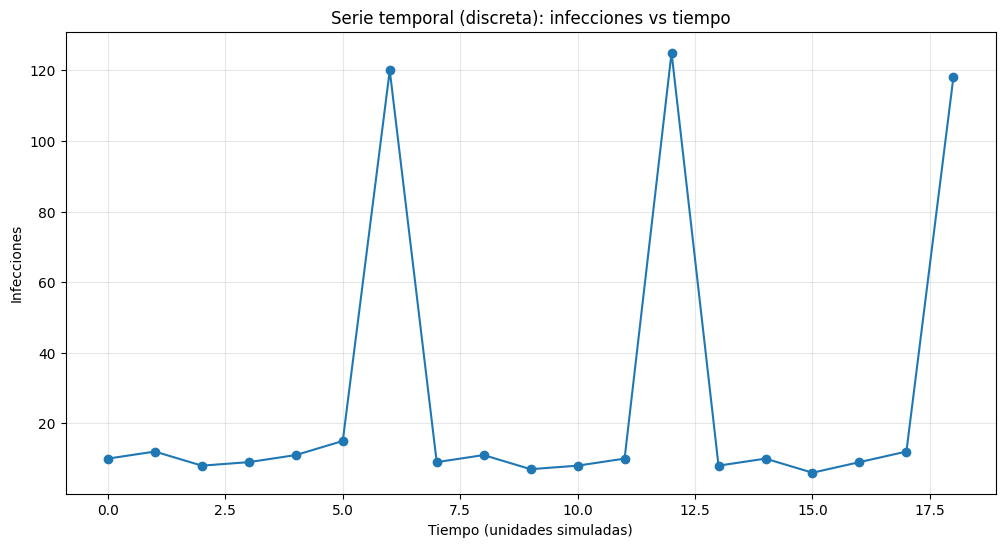

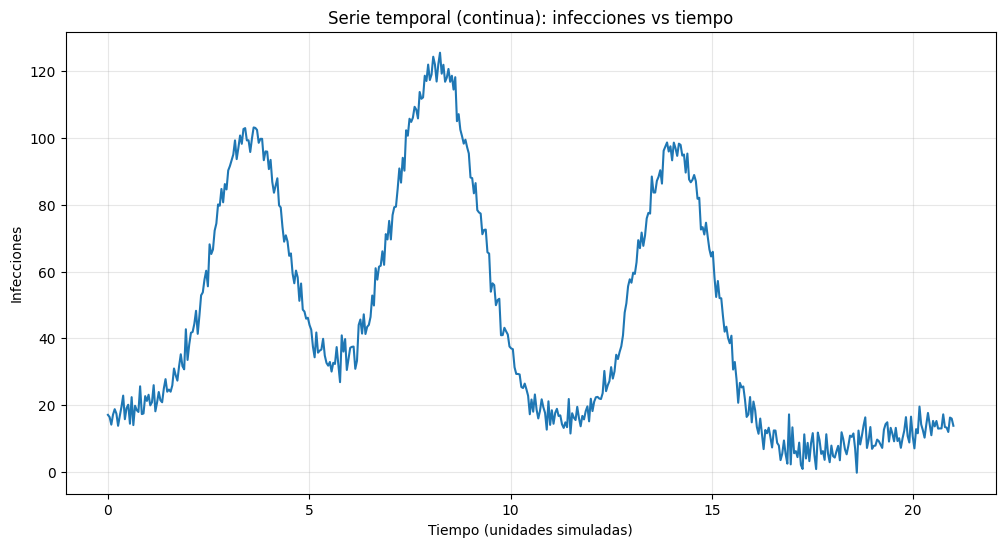

In [4]:
# graficos
# Serie temporal (discreta)
plot_time_series(
    data['discrete']['timestamps'],
    data['discrete']['infections'],
    'Serie temporal (discreta): infecciones vs tiempo',
    xlabel='Tiempo (unidades simuladas)'
)

# Serie temporal (continua)
plot_time_series(
    data['continuous']['timestamps'],
    data['continuous']['infections'],
    'Serie temporal (continua): infecciones vs tiempo',
    xlabel='Tiempo (unidades simuladas)'
)
plt.show()


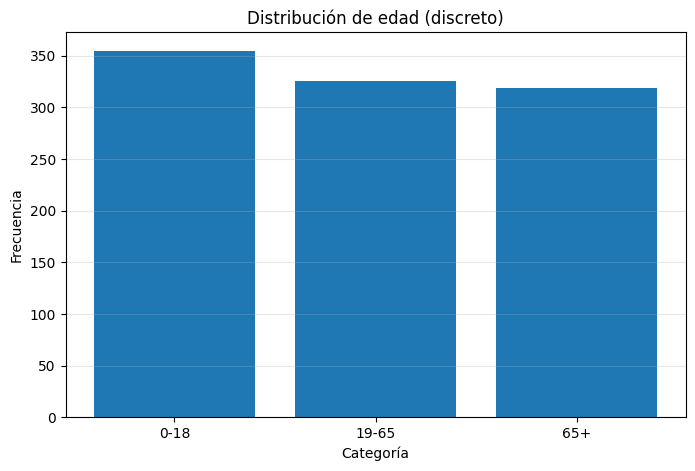

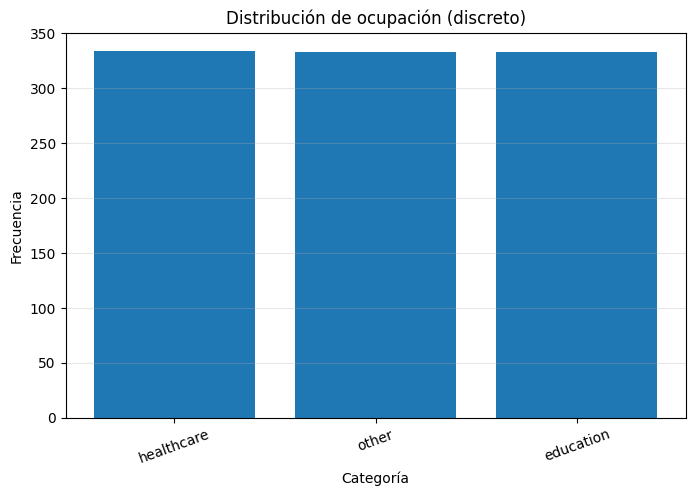

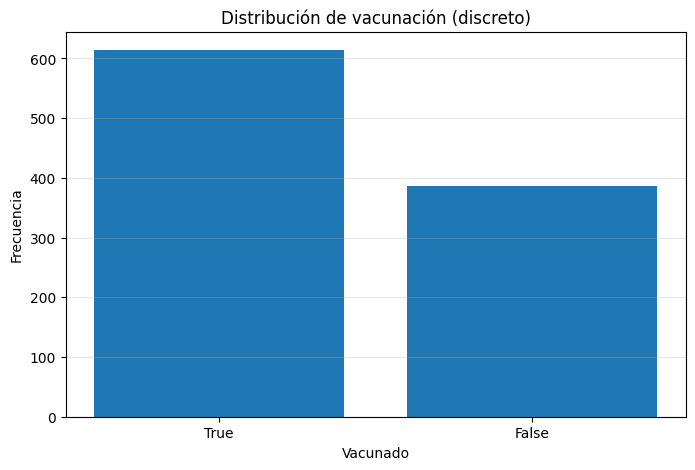

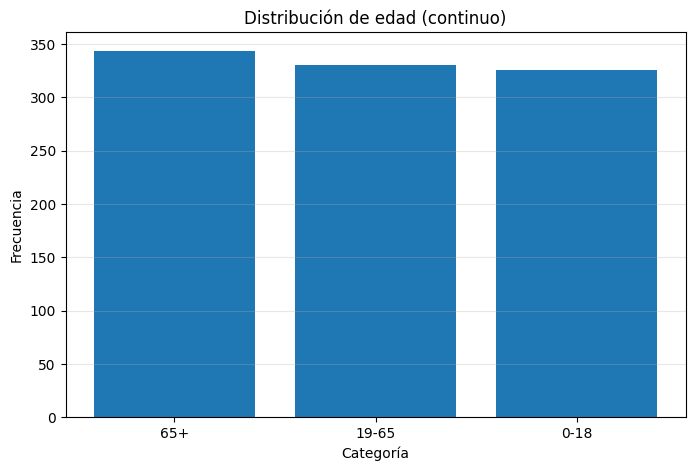

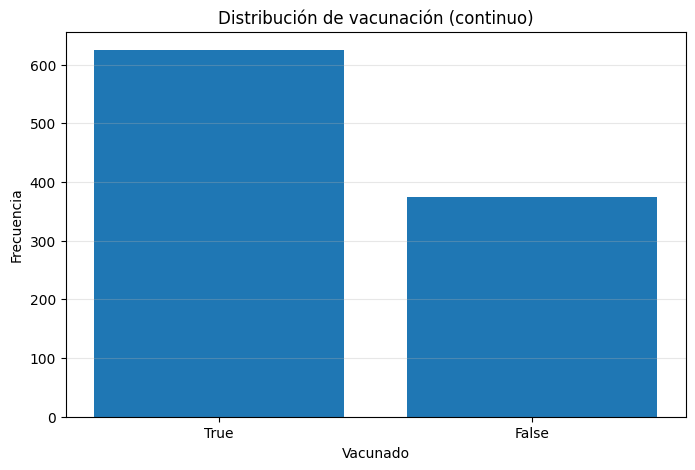

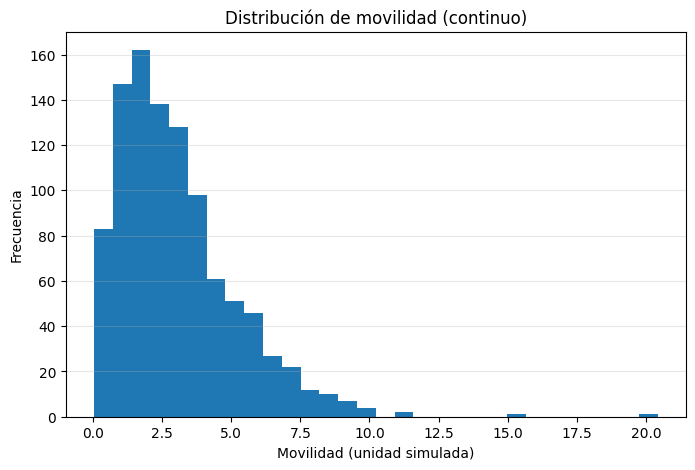

In [5]:

# Histogramas (discreto)
plot_categorical_hist(
    data['discrete']['agent_data']['age'],
    'Distribución de edad (discreto)',
    rotate=0
)
plot_categorical_hist(
    data['discrete']['agent_data']['occupation'],
    'Distribución de ocupación (discreto)',
    rotate=20
)
plot_categorical_hist(
    data['discrete']['agent_data']['vaccinated'],
    'Distribución de vacunación (discreto)',
    xlabel='Vacunado'
)

# Histogramas (continuo)
plot_categorical_hist(
    data['continuous']['agent_data']['age'],
    'Distribución de edad (continuo)',
    rotate=0
)
plot_categorical_hist(
    data['continuous']['agent_data']['vaccinated'],
    'Distribución de vacunación (continuo)',
    xlabel='Vacunado'
)
plot_numeric_hist(
    data['continuous']['agent_data']['mobility'],
    'Distribución de movilidad (continuo)',
    xlabel='Movilidad (unidad simulada)',
    bins=30
)

plt.show()


¿Los recuentos de infecciones se informan a intervalos regulares (por ejemplo, diarios) o irregulares? 
o ¿Observa intervalos sin infecciones entre los períodos de informe?

En el caso de los discretos, los recuentos estan en intervalos regulares  de 1 dia, que hay picos semanales en los valores pero el espaciado de tiempo es diario. Luego en el continuo se muestrea de forma regular en 500 puntos uniformes entre 0 y 21 en la grafica. En los datos discretos no hay intervalos sin infecciones. Y en el continuo es raro cuando esta en 0, pero tampoco hay periodos sin informe. 


### paso 2 identificacion del modelo temporal

In [6]:
import pandas as pd

# Alinea longitudes (si difieren) y devuelve Series 0..n-1.
def align_xy(t, y):
    t = pd.Series(t)
    y = pd.Series(y)
    n = min(len(t), len(y))
    return t.iloc[:n].reset_index(drop=True), y.iloc[:n].reset_index(drop=True)

def detect_peaks(y, k=2.0, min_sep_points=3):
    """
    Picos por umbral robusto (mediana + k*MAD) + máximo local.
    min_sep_points: separación mínima entre picos (en índices).
    """
    y = pd.Series(y).reset_index(drop=True)
    med = y.median()
    mad = (y - med).abs().median()
    thr = med + k * mad

    # max locales y sobre umbral
    is_peak = (y > y.shift(1)) & (y >= y.shift(-1)) & (y >= thr)
    cand_idx = y[is_peak].index.tolist()

    cand_idx = sorted(cand_idx, key=lambda i: y.iloc[i], reverse=True)
    selected = []
    for i in cand_idx:
        if all(abs(i - s) >= min_sep_points for s in selected):
            selected.append(i)
    selected = sorted(selected)

    return pd.DataFrame({
        "peak_idx": selected,
        "y_peak": y.iloc[selected].values
    })

#Tabla de Δt entre picos consecutivos
def peak_intervals(t, peaks_idx):
    s = pd.Series(t).reset_index(drop=True).to_numpy()
    tp = s[peaks_idx]
    if tp.size < 2:
        return pd.DataFrame(columns=["t_from","t_to","delta_t"])
    t_from = tp[:-1]
    t_to   = tp[1:]
    return pd.DataFrame({"t_from": t_from, "t_to": t_to, "delta_t": t_to - t_from})


"""
Proporción de puntos 'entre picos' por encima de un umbral pequeño.
- discrete=True  -> umbral=0 por defecto.
- discrete=False -> umbral=percentil 5 por defecto.
"""
def low_level_transmission(t, y, peaks_idx, small_threshold=None, discrete=False):

    t = pd.Series(t).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)

    if small_threshold is None:
        small_threshold = 0 if discrete else y.quantile(0.05)

    rows = []
    for a, b in zip(peaks_idx[:-1], peaks_idx[1:]):
        if b - a <= 1:
            prop = 0.0
        else:
            seg = y.iloc[a+1:b]

            prop = float((seg > small_threshold).mean())
        rows.append({
            "t_from": t.iloc[a],
            "t_to": t.iloc[b],
            "prop_above_small": prop
        })

    df = pd.DataFrame(rows)
    overall = float(df["prop_above_small"].mean()) if not df.empty else float("nan")
    return df, overall, small_threshold



#True si todos los timestamps son enteros
def likely_discrete_time(t, tol=1e-9):
    s = pd.Series(t)
    return ((s.round().sub(s).abs() < tol)).all()

#discreta
td, yd = align_xy(data["discrete"]["timestamps"], data["discrete"]["infections"])
peaks_d = detect_peaks(yd, k=2.0, min_sep_points=2)
intervals_d = peak_intervals(td, peaks_d["peak_idx"].tolist())
between_d, overall_d, thr_d = low_level_transmission(td, yd, peaks_d["peak_idx"].tolist(),
                                                     discrete=True)

print("\n== Discreta ==")
print("Picos:\n", peaks_d)
print("Intervalos entre picos (Δt):\n", intervals_d)
print("Entre picos (proporción > umbral pequeño):\n", between_d)
print(f"Proporción media entre picos: {overall_d:.3f} | Umbral usado: {thr_d}")

# pequeña métrica de periodicidad (CV de Δt)
if not intervals_d.empty:
    mu, sigma = intervals_d["delta_t"].mean(), intervals_d["delta_t"].std(ddof=1)
    cv_d = float(sigma / mu) if mu else float("nan")
else:
    cv_d = float("nan")
print(f"CV Δt (discreta): {cv_d}")

# continua
tc, yc = align_xy(data["continuous"]["timestamps"], data["continuous"]["infections"])
peaks_c = detect_peaks(yc, k=2.0, min_sep_points=40)  # separación mayor para 500 puntos
intervals_c = peak_intervals(tc, peaks_c["peak_idx"].tolist())
between_c, overall_c, thr_c = low_level_transmission(tc, yc, peaks_c["peak_idx"].tolist(),
                                                     discrete=False)

print("\n== Continua ==")
print("Picos:\n", peaks_c)
print("Intervalos entre picos (Δt):\n", intervals_c)
print("Entre picos (proporción > umbral pequeño):\n", between_c)
print(f"Proporción media entre picos: {overall_c:.3f} | Umbral usado (p5): {thr_c:.3f}")

if not intervals_c.empty:
    mu, sigma = intervals_c["delta_t"].mean(), intervals_c["delta_t"].std(ddof=1)
    cv_c = float(sigma / mu) if mu else float("nan")
else:
    cv_c = float("nan")
print(f"CV Δt (continua): {cv_c}")

#inficadores como el pseudocódigo 
# picos casi periódicos
ev_disc = int((not pd.isna(cv_d)) and (cv_d < 0.25))
# hay “bajo nivel” entre picos
ev_cont_d = int(overall_d > 0.5)
ev_cont_c = int(overall_c > 0.5)

print("\nHeurísticas:")
print("likely_discrete_time(discreta):", likely_discrete_time(td))
print("evidence_for_discrete_time(discreta, CV<0.25):", ev_disc)
print("evidence_for_continuous_time(discreta, >50% entre picos):", ev_cont_d)
print("likely_continuous_time(continua):", not likely_discrete_time(tc))
print("evidence_for_continuous_time(continua, >50% entre picos):", ev_cont_c)



== Discreta ==
Picos:
    peak_idx  y_peak
0         6     120
1        12     125
Intervalos entre picos (Δt):
    t_from  t_to  delta_t
0       6    12        6
Entre picos (proporción > umbral pequeño):
    t_from  t_to  prop_above_small
0       6    12               1.0
Proporción media entre picos: 1.000 | Umbral usado: 0
CV Δt (discreta): nan

== Continua ==
Picos:
    peak_idx      y_peak
0        86  103.137679
1       196  125.512871
2       330   98.641159
Intervalos entre picos (Δt):
      t_from       t_to   delta_t
0  3.619238   8.248497  4.629259
1  8.248497  13.887776  5.639279
Entre picos (proporción > umbral pequeño):
      t_from       t_to  prop_above_small
0  3.619238   8.248497               1.0
1  8.248497  13.887776               1.0
Proporción media entre picos: 1.000 | Umbral usado (p5): 6.769
CV Δt (continua): 0.1391029733481734

Heurísticas:
likely_discrete_time(discreta): True
evidence_for_discrete_time(discreta, CV<0.25): 0
evidence_for_continuous_time(dis

¿Podrían los patrones observados ser artefactos del modelo temporal? 

Si, porque en la discreta, en la transmisión de bajo nivel sale sólo porque el umbral = 0 y no hay ceros entonces es un  artefacto. Mientras que en la continua los picos estan espaciados, que eso puede que sea por como se generlo la serie con tres gausseanos con periocidad, y el baseline deja valores entre picos por encima del p5 casi siempre. 

### Paso 3: Análisis del Impacto de Rasgos

In [7]:
# Datos
disc = data["discrete"]
agents = disc["agent_data"].copy()
total_infections = np.sum(disc["infections"])

# Multiplicadores usados en el escenario ponderado 
age_w = {"0-18": 0.9, "19-65": 1.0, "65+": 1.3}
vac_w = {True: 0.6, False: 1.0}

def rr_by_trait(trait, weights):
    s = agents[trait]
    pop = s.value_counts()
    w = pd.Series(1.0, index=pop.index)
    for k, v in (weights or {}).items():
        if k in w.index:
            w.loc[k] = float(v)
    alloc = total_infections * (pop * w) / (pop * w).sum()
    ar = alloc / pop
    base = ar.idxmin()  # grupo con menor tasa
    rr = ar / ar.loc[base]
    df = pd.DataFrame({"population": pop, "weight": w, "AR": ar, "RR": rr}).sort_values("RR", ascending=False)
    return df, base

age_df, age_base = rr_by_trait("age", age_w)
occ_df, occ_base = rr_by_trait("occupation", {"healthcare":1.2, "education":1.0, "other":0.9})
vac_df, vac_base = rr_by_trait("vaccinated", vac_w)

print("RR por edad (base =", age_base, ")\n", age_df, "\n")
print("RR por ocupación (base =", occ_base, ")\n", occ_df, "\n")
print("RR por vacunación (base =", vac_base, ")\n", vac_df, "\n")

# Interacción edad × vacunación ---
pop_axv = agents.groupby(["age", "vaccinated"]).size().rename("population")
w_age = pd.Series(age_w)
w_vac = pd.Series(vac_w)

# Alinear índices
pop_axv = pop_axv.reset_index()
pop_axv["weight"] = pop_axv.apply(lambda r: float(w_age[r["age"]]) * float(w_vac[r["vaccinated"]]), axis=1)

alloc = total_infections * (pop_axv["population"] * pop_axv["weight"]) / (pop_axv["population"] * pop_axv["weight"]).sum()
ar = alloc / pop_axv["population"]
pop_axv["AR"] = ar.values

# baseline = (0-18, True)
baseline_mask = (pop_axv["age"]=="0-18") & (pop_axv["vaccinated"]==True)
ar_base = float(pop_axv.loc[baseline_mask, "AR"].iloc[0])

pop_axv["RR_vs_(0-18,True)"] = pop_axv["AR"] / ar_base

# Ordenado por RR desc
axv_df = pop_axv.sort_values("RR_vs_(0-18,True)", ascending=False)

print("Edad × Vacunación (RR vs (0-18, True))\n", axv_df, "\n")

# agregados
max_rr = axv_df["RR_vs_(0-18,True)"].max()
max_group = axv_df.loc[axv_df["RR_vs_(0-18,True)"].idxmax(), ["age","vaccinated"]].to_dict()
print(f"Máximo RR combinado edad×vacunación: {max_rr:.3f} en grupo {max_group}")


RR por edad (base = 0-18 )
        population  weight        AR        RR
age                                          
65+           319     1.3  0.635163  1.444444
19-65         326     1.0  0.488587  1.111111
0-18          355     0.9  0.439728  1.000000 

RR por ocupación (base = other )
             population  weight        AR        RR
occupation                                        
healthcare         334     1.2  0.601451  1.333333
education          333     1.0  0.501209  1.111111
other              333     0.9  0.451089  1.000000 

RR por vacunación (base = True )
             population  weight        AR        RR
vaccinated                                        
False              386     1.0  0.686638  1.666667
True               614     0.6  0.411983  1.000000 

Edad × Vacunación (RR vs (0-18, True))
      age  vaccinated  population  weight        AR  RR_vs_(0-18,True)
4    65+       False         120    1.30  0.842255           2.407407
2  19-65       False         

¿Qué rasgo muestra la mayor correlación con el riesgo de infección? 
o ¿Existen efectos de interacción (p. ej., personas mayores + no vacunadas)? a

El rasgo que muestra mayor correlacion es el estado de vacunacion, ya que tiene un resultado de 1.67, luego la edad con un RR de 65+ y de 0-18 con un 1.44. Y por ultimo la ocupacion de healthcare vrs other que es de 1.33.

Acerca de la interacción edad x vacunación, el grupo 65+ y no vacunado tiene RR ≈ 2.41 frente a (0–18, vacunado).

Aqui parece que al no estar vacunado es el factor más asociado al riesgo, mayores no vacunados 2.4× más riesgo que adolescentes vacunados.


## Paso 4: Pruebas de validación 

C:\Users\angel\AppData\Local\Temp\ipykernel_53928\2172704530.py:56: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  agg = df.groupby(g, as_index=False).agg(


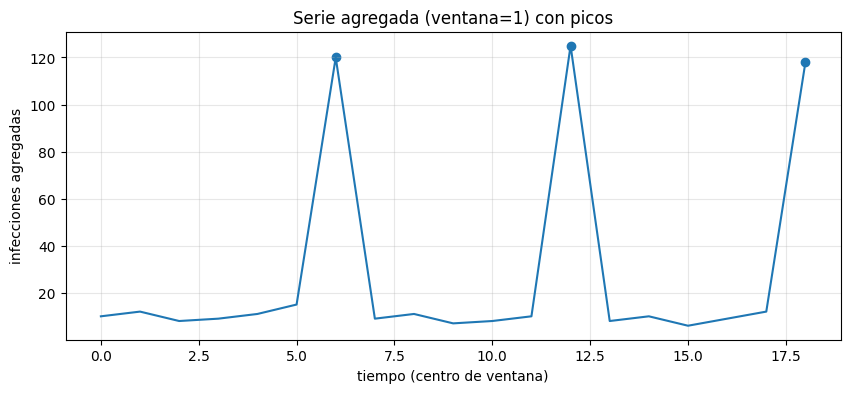

C:\Users\angel\AppData\Local\Temp\ipykernel_53928\2172704530.py:56: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  agg = df.groupby(g, as_index=False).agg(


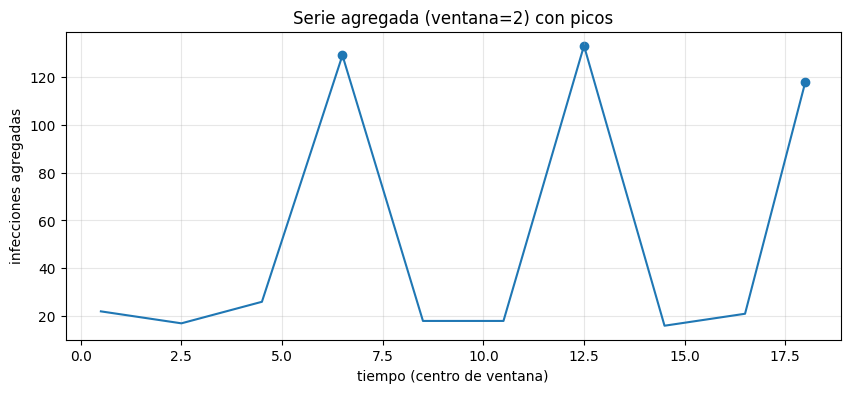

C:\Users\angel\AppData\Local\Temp\ipykernel_53928\2172704530.py:56: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  agg = df.groupby(g, as_index=False).agg(


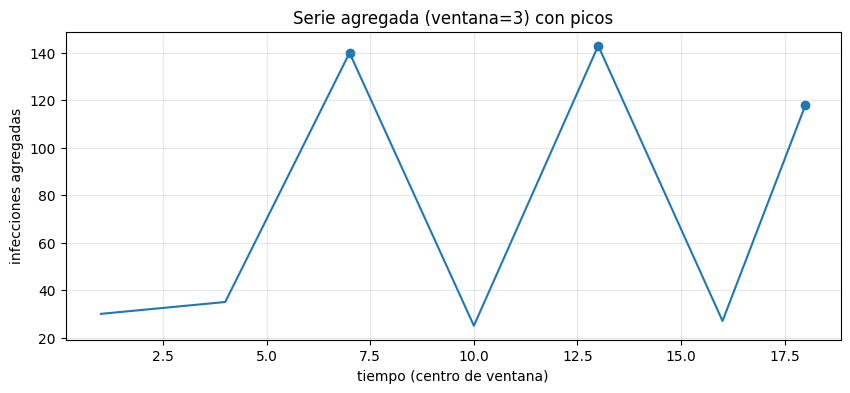

C:\Users\angel\AppData\Local\Temp\ipykernel_53928\2172704530.py:56: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  agg = df.groupby(g, as_index=False).agg(


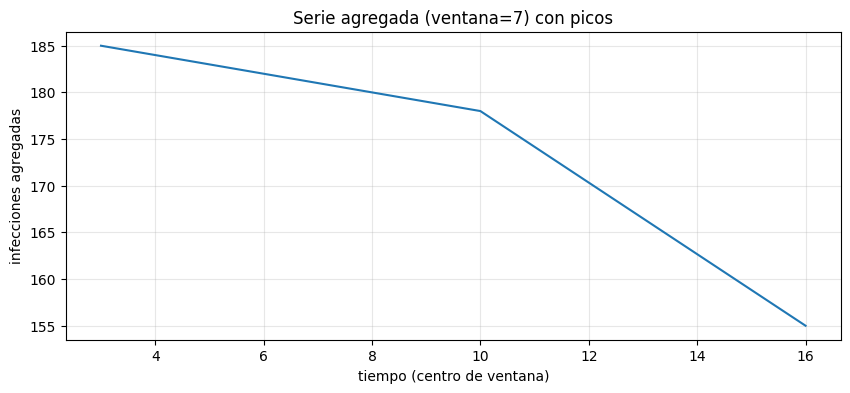

C:\Users\angel\AppData\Local\Temp\ipykernel_53928\2172704530.py:56: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  agg = df.groupby(g, as_index=False).agg(


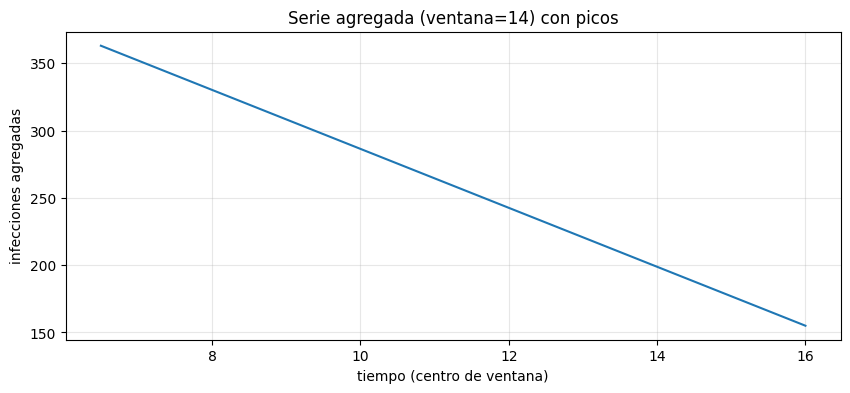


=== Sensibilidad temporal (discreto) ===
 window  num_points  num_peaks  mean_dt    cv_dt  between_peak_prop(>0)
      1          19          3     6.00 0.000000                    1.0
      2          10          3     5.75 0.061488                    1.0
      3           7          3     5.50 0.128565                    1.0
      7           3          0      NaN      NaN                    NaN
     14           2          0      NaN      NaN                    NaN

prueba de aleatorización
            observed_RR_max  null_median  null_p05  null_p95  empirical_p_value
trait                                                                          
age                1.444444     1.444444  1.444444  1.444444                1.0
occupation         1.333333     1.333333  1.333333  1.333333                1.0
vaccinated         1.666667     1.666667  1.666667  1.666667                1.0


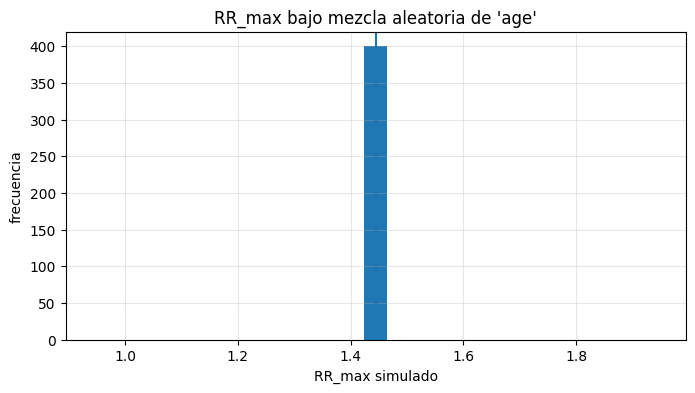

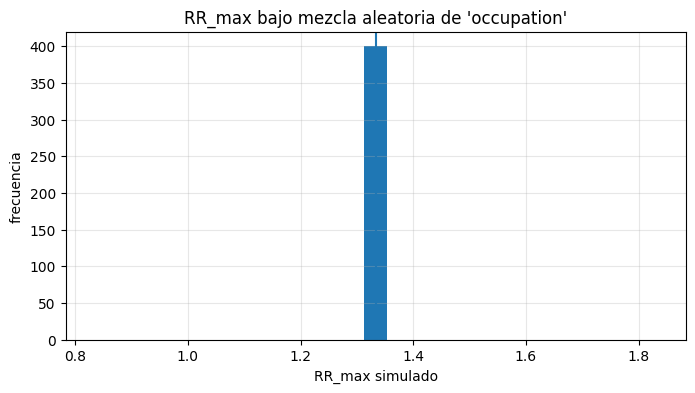

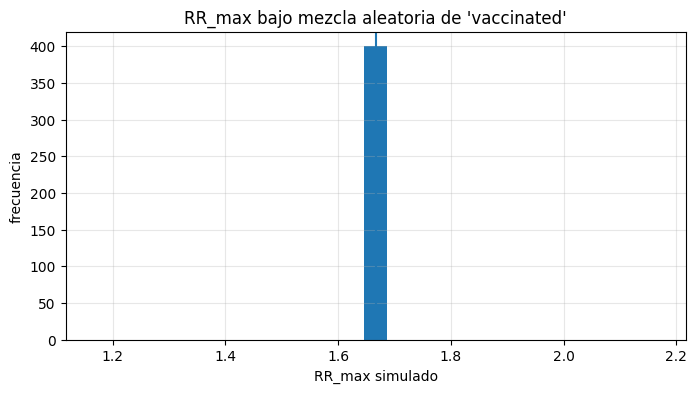

In [8]:

np.random.seed(123)

# discreto 
disc = data["discrete"]
t = np.asarray(disc["timestamps"])
y = np.asarray(disc["infections"])
agents = disc["agent_data"].copy()

# serie
def align_xy(x, y):
    n = min(len(x), len(y))
    return np.asarray(x)[:n], np.asarray(y)[:n]

def mad(a):
    a = np.asarray(a)
    med = np.median(a)
    return np.median(np.abs(a - med))

def detect_peaks(y, k=2.0, min_sep=2):
    y = np.asarray(y)
    thr = np.median(y) + k*mad(y)
    # máximos locales
    cand = np.where((y[1:-1] > y[:-2]) & (y[1:-1] >= y[2:]) & (y[1:-1] >= thr))[0] + 1
    # extremos
    if y[0] >= thr and y[0] > y[1]: cand = np.r_[0, cand]
    if y[-1] >= thr and y[-1] > y[-2]: cand = np.r_[cand, len(y)-1]
    # separación mínima (NMS por altura)
    order = cand[np.argsort(y[cand])[::-1]]
    sel = []
    for idx in order:
        if all(abs(idx - s) >= min_sep for s in sel):
            sel.append(idx)
    return np.array(sorted(sel), dtype=int)

def between_peak_prop(y, peaks, small_threshold=0):
    y = np.asarray(y)
    if len(peaks) < 2:
        return np.nan
    props = []
    for a, b in zip(peaks[:-1], peaks[1:]):
        if b - a <= 1:
            props.append(0.0)
            continue
        seg = y[a+1:b]
        props.append(float((seg > small_threshold).mean()))
    return float(np.mean(props))

# Reagregación temporal 
def reaggregate_and_assess(t, y, windows=(1,2,3,7,14)):
    x, z = align_xy(t, y)
    df = pd.DataFrame({"t": x, "y": z})
    rows = []
    for w in windows:
        # asignar ventana por piso(t/w)
        g = (df["t"] // w).astype(int)
        agg = df.groupby(g, as_index=False).agg(
            t_min=("t","min"),
            t_max=("t","max"),
            infections=("y","sum")
        )
        # construir eje temporal por centro de la ventana (útil para graficar)
        agg["t_center"] = (agg["t_min"] + agg["t_max"]) / 2.0

        # detectar picos sobre la serie agregada
        peaks = detect_peaks(agg["infections"].values, k=2.0, min_sep=1)
        t_peaks = agg["t_center"].values[peaks]
        intervals = np.diff(t_peaks) if len(t_peaks) >= 2 else np.array([])
        mean_dt = float(np.mean(intervals)) if intervals.size else np.nan
        std_dt  = float(np.std(intervals, ddof=1)) if intervals.size >= 2 else np.nan
        cv_dt   = float(std_dt/mean_dt) if (not np.isnan(std_dt) and mean_dt) else np.nan

        # bajo nivel entre picos (umbral = 0 para discrete)
        low_prop = between_peak_prop(agg["infections"].values, peaks, small_threshold=0)

        rows.append({
            "window": w,
            "num_points": len(agg),
            "num_peaks": int(len(peaks)),
            "mean_dt": mean_dt,
            "cv_dt": cv_dt,
            "between_peak_prop(>0)": low_prop
        })

        # gráfico 1 por ventana
        plt.figure(figsize=(10,4))
        plt.plot(agg["t_center"], agg["infections"])
        if len(peaks):
            plt.scatter(agg["t_center"].values[peaks], agg["infections"].values[peaks])
        plt.title(f"Serie agregada (ventana={w}) con picos")
        plt.xlabel("tiempo (centro de ventana)")
        plt.ylabel("infecciones agregadas")
        plt.grid(True, alpha=0.3)
        plt.show()

    return pd.DataFrame(rows).sort_values("window")

sens_time_df = reaggregate_and_assess(t, y, windows=(1,2,3,7,14))
print("\n=== Sensibilidad temporal (discreto) ===")
print(sens_time_df.to_string(index=False))

#  rasgos y comparar RR 
age_w = {"0-18": 0.9, "19-65": 1.0, "65+": 1.3}
occ_w = {"healthcare": 1.2, "education": 1.0, "other": 0.9}
vac_w = {True: 0.6, False: 1.0}

TOTAL_INF = y.sum()

def rr_max_for_trait(agents_df, trait, weights):
    s = agents_df[trait]
    pop = s.value_counts()
    w = pd.Series(1.0, index=pop.index, dtype=float)
    for k, v in (weights or {}).items():
        if k in w.index:
            w.loc[k] = float(v)
    alloc = TOTAL_INF * (pop * w) / (pop * w).sum()
    ar = alloc / pop
    base = ar.idxmin()
    rr = ar / ar.loc[base]
    return float(rr.max()), rr, base

def randomization_test(agents_df, trait, weights, n_iter=300):
    """Mezcla aleatoriamente el rasgo y calcula la distribución de RR_max."""
    obs_rr_max, obs_rr_vec, base = rr_max_for_trait(agents_df, trait, weights)
    rr_max_null = np.empty(n_iter, dtype=float)
    for i in range(n_iter):
        shuffled = agents_df.copy()
        shuffled[trait] = np.random.permutation(shuffled[trait].values)
        rr_max_null[i], _, _ = rr_max_for_trait(shuffled, trait, weights)
    # p-valor empírico unilateral (≥ observado)
    p = (np.sum(rr_max_null >= obs_rr_max) + 1) / (n_iter + 1)
    q05, q50, q95 = np.percentile(rr_max_null, [5, 50, 95])
    return {
        "trait": trait,
        "observed_RR_max": obs_rr_max,
        "null_median": q50,
        "null_p05": q05,
        "null_p95": q95,
        "empirical_p_value": p
    }, rr_max_null

tests = []
distros = {}

for trait, weights in [("age", age_w), ("occupation", occ_w), ("vaccinated", vac_w)]:
    res, null_dist = randomization_test(agents, trait, weights, n_iter=400)
    tests.append(res)
    distros[trait] = null_dist

sens_traits_df = pd.DataFrame(tests).set_index("trait")
print("\nprueba de aleatorización")
print(sens_traits_df.to_string())

# Histogramas (1 figura por rasgo)
for trait in ["age", "occupation", "vaccinated"]:
    plt.figure(figsize=(8,4))
    plt.hist(distros[trait], bins=25)
    plt.axvline(sens_traits_df.loc[trait, "observed_RR_max"])
    plt.title(f"RR_max bajo mezcla aleatoria de '{trait}'")
    plt.xlabel("RR_max simulado")
    plt.ylabel("frecuencia")
    plt.grid(True, alpha=0.3)
    plt.show()


las propuestas de datos reales necesarios para la validación
informes de casos reales por grupo demográfico

En internet hay bastante información que informa acerca que la vacunación es el factor con mayor asociación al riesgo. Siendo mayores no vacunados >> adolecentes vacunados.

Los informes encontrados son:

https://www.cdc.gov/mmwr/volumes/71/wr/mm7107e4.htm
Adolescentes (12–17 años): durante Delta/Ómicron, los no vacunados tuvieron tasas de hospitalización x6 (y en otro periodo x10) más altas que los vacunados.


https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2796235?
https://www.cdc.gov/mmwr/volumes/71/wr/mm7104e2.htm
Adultos: las hospitalizaciones fueron x10.5 más altas en no vacunados que en vacunados; para muertes, los no vacunados tuvieron razones aún mayores frente a los vacunados.


datos de movilidad de telefonos moviles:
Con esto se puede ver la mocilidad de una comunidad debido a la vacunacion, lo que se encontró son esots datos de google, acerca del covid-19:
https://www.google.com/covid19/mobility/

y esta de meta: 
https://data.humdata.org/dataset/movement-range-maps

para la validación, lo que se podría hacer es construir un índice de movilidad por municipio, probar lags, combinar movilidad por municipio con tasas por edad/ vacunación para ver si los picos se explican mejor cuando cae la movilidad en áreas con baja cobertura de vacunación. 


¿Cómo distinguiría a los verdaderos supercontagiadores de los artefactos de modelado?

Un verdadero supercontagiado es alguien cuya probabilidad de transmitir por contacto se mantiene inusualmente alta incluso después de ajustar por cuántos contactos tuvo, en qué contextos  como un evento masivo, con ventilación, duración, rasgos propios (edad, vacunación) y sesgos de detección.Para poder distinguirlo de artefactos, usa datos con enlaces de transmisión/contactos y modela la transmisión por contacto (efectos aleatorios por persona y por evento), normaliza por número y tipo de contactos, estima la sobredispersión y verifica que el efecto individual permanezca significativo. Probar robustez como reagregar tiempo, regularización. Si el efecto persiste en todas las  pruebas, es probable que sea real y si se desvanece, seguramente era un artefacto.

## Referencias:
- Reyes, C. (2018, marzo 24). Relación entre sistemas de control en tiempo continuo y en tiempo discreto. Control digital. Herramientas de cálculo. https://herramientasdecalculo.com/2018/03/24/1-2-relacion-entre-sistemas-de-control-en-tiempo-continuo-y-en-tiempo-discreto-control-digital/

- Juanweb. (2023, octubre 1). Simulación de eventos discretos con SimPy en Python. CodigosPython. https://codigospython.com/simulacion-de-eventos-discretos-con-simpy-en-python/

 